# Customer-Life-Time-Value (CLV)
`CLV Overview`
* This is often referred to as Customer Lifetime Value (CLV), Recency, Frequency, Monetary Value (RFM) or Customer Probability Models etc
* These models focus exclusively on how customers make repeat purchases over their own lifetime relationship with the company
* Cameron Pilon transformed their CLV work into an easily implementable python code package called [lifetimes](https://github.com/CamDavidsonPilon/lifetimes)

I am applying analysis to company (Olist) and carefully examining registered customer orders, dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil
* Olist is a Brazilian online e-commerce department store
  * Olist connects small businesses from all over Brazil to channels without hassle and with a single contract
  * These merchants are able to sell their products through Olist Store and ship them directly to customers using Olist logistics partners 

-----
`Steps to take:`
1. From the data-set, I extract Olist best customers through forecasting their future purchases
2. Then analyze their historical purchasing paths, infer their probability of leaving and generalize Olist customers via RF Matrices
3. Take models presented one step further and perform a bottom-up financial valuation of Olist to determine how much it is worth today

-----
`How Modelling will be done??`
First step to customer analysis is to find a good mathematical model to describe customer repeat purchases <br>
This doesn't have to get complicated, Fader and Hardie only considers timing as a primary factor. Who is Fader and Hardie???
Few well-established models proposed are as:
* `Pareto/NBD Model` by [Schmittlein et al.](https://www.jstor.org/stable/24571167) in 1984
* `BG/NBD Model` was later proposed by [Fader and Hardie](http://www.brucehardie.com/papers/bgnbd_2004-04-20.pdf) in 2004 => An alternate and easier to implement model then Pareto/NBD Model
* [BG/BB Model](https://web-docs.stern.nyu.edu/old_web/emplibrary/Peter%20Fader.pdf) in 2009 => more recent model
I will be introducing and actively using `BG/NBD model` within our analysis, both `Pareto/NBD` and `BG/NBD` are supported within `lifetimes`<br>
## A quick goto of `BG/NBD Model`: 
* Customers will come and buy at an interval that's randomly distributed within a reasonable time range
* After each purchase they have a certain probability of dying or becoming inactive (never returning to buy again)
* Each customer is different and have varying purchase intervals and probability of going inactive

## `Model Mathematical Specification`:
* Customers buy `stochastically` according to a Poisson distribution with purchasing rate `(λ)-lambda`
* After each purchase customer has `p%` chance of becoming inactive 
  * so time period at which a customer becomes inactive is distributed as a shifted geometric distribution
* customer-base is `heterogeneous` across those two parameters such that we can assume a `(γ)-gamma` and `(β)-beta distribution` respectively
* at last we assume that `λ` and `p%` across customers are jointly independent
  * This makes some of math later on much easier
<h1>`λ ~ γ(a,r),p ~ β(a,b)`</h1>

## `Family of Models`:
* This class of models try to quantify customer behavior under a `non-contractual setting` where we don't know when customers become inactive but rather assign a percentage confidence that we believe they are dead
  * In contrast, another class of models are designed for `contractual settings` and have been successfully applied to other businesses such as telecommunication industry where a customer has to tell you that they're ending their relationship
    * Example: Large number of subscriber-based firms like Netflix often report and describe their churn rate or customer turnover. CLV is much simpler to quantify on that scale but for a normal product-selling firm, this is much more difficult as were not sure when a customer has decided to terminate relationship
* Having a model that can describe customer `deaths` and `purchases over time` is much more effective at inferring their future purchases and subsequent aggregation into expected total sales than a naive "oh I expect goods sale to grow at maybe 1% next year". This I will shown in details later on with some simple plots

# `What kind of data does this BG/NBD Model requires???`
`BG/NBD model`: only requires three primary components along with one additional for each unique customer:
1. `Frequency`: Number of repeat purchases that they have made
2. `Recency`: When was the last time that they have made a purchase since their first purchase
3. `Monetary Value`: 
4. `Customer Age`: End of our observation period minus out the period that they made their first purchase
These four components together is called an **`RFM Matrix`** <br>
`Now its time to find Olist Brazilian online e-commerce department store RFM matrix of all customers` <br>
* for finding this **`RFM Matrix`** first we have to arrange and collect out data in one single dataframe, as data is in multiple dataframes i.e. A total of 8 dataframe

# `When to use CLV??`
Lifetimes can be used to analyze users based on a few assumption:
1. Users interacts when they are `alive`
2. Users under study may `die` after some period of time
`alive` and `die` => most abstract terms: own definition of `alive` and `die` (they are used similarly to `birth` and `death` in survival analysis) <br>
Whenever we have individuals repeating occurrences, we can use Lifetimes to help understand user behaviour

# `What are the Applications of CLV??`
Consider these applications to understand more:
* Predicting how often a visitor will return to your website. (Alive = visiting, Die = decided website wasn't for them)
* Understanding how frequently a patient may return to a hospital. (Alive = visiting, Die = maybe patient moved to a new city, or became deceased)
* Predicting individuals who have churned from an app using only their usage history. (Alive = logins, Die = removed app)
* `Predicting repeat purchases from a customer. (Alive = actively purchasing, Die = became disinterested with your product)`
* `Predicting lifetime value of your customers`

# `Assumptions about purchase event process and time that customer stays active(alive)` 
* These five assumptions are given in words here.I will attempt to convince that these assumptions are sensible, and then present formalized mathematics of the model

`Individual Customer`
1. `Poisson Purchases`:While alive,each customer makes purchases according to a Poisson process with rate `λ`
2. `Exponential Lifetime`: Each customer remains alive for a lifetime which has an exponentially distributed duration with death rate `μ`

`Heterogeneity Across Customers`<br>

3. `Individuals'Purchasing Rates Distributed Gamma`:Purchasing rate `λ` for different customers is distributed according to a gamma distribution across population of customers<br>
4. `Death Rates Distributed Gamma`:Customer's death rates `μ` are distributed accordingto a different gamma distribution across customers <br>
5. `Rates λ and μ Are Independent`:Purchasing rates `λ` and death rates `μ` are distributed independently of each other


# Loading all data frames

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Above are all the data bases we have but we are selecting required database for CLV problem

These are databases which we will use:
* olist_orders_dataset.csv
* olist_customers_dataset.csv
* olist_order_payments_dataset.csv

In [3]:
# figure size(can be used as global)
%matplotlib inline
import matplotlib.pyplot as plt #ploting
plt.rcParams['figure.figsize'] = (14,4) 
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
sns.set_context("poster",font_scale=.5,rc={"grid.linewidth":5})

import warnings
warnings.filterwarnings('ignore') #ignore warnings [dont show them to me ]

<div class="alert alert-block alert-info">
<b>Tip:</b><br> 
`%matplotlib inline` function is used to render static matplotlib plots within Jupyter notebook<br> 
Try replacing `inline` part with `notebook` to get zoom-able & resize-able plots, easily
</div>


In [4]:
path = '/input/brazilian-ecommerce/'

orders = pd.read_csv(path+'olist_orders_dataset.csv')
customers = pd.read_csv(path+'olist_customers_dataset.csv')
payments = pd.read_csv(path+'olist_order_payments_dataset.csv')

In [5]:
merged_df1 = orders.merge(customers,on='customer_id',how='outer')
merged_df1 = merged_df1.merge(payments,on='order_id',how='outer')

merged_df1.reset_index(inplace=True)
merged_df1.head(2)

In [6]:
merged_df1.isnull().sum()

In [7]:
req_cols = ['customer_unique_id','order_purchase_timestamp','payment_value']
merged_df1 = merged_df1[req_cols]

merged_df1.head()

In [8]:
merged_df1.shape

In [9]:
merged_df1.isnull().sum()

In [10]:
merged_df1.info()

In [11]:
# changing order_purchase_timestamp which is string data type to datetime data type
merged_df1['order_purchase_timestamp'] = pd.to_datetime(merged_df1['order_purchase_timestamp'])

# extracting date
merged_df1['order_date'] = merged_df1.order_purchase_timestamp.dt.date
merged_df1['order_date'] = pd.to_datetime(merged_df1['order_date'])
merged_df1.head(2)

In [12]:
col = ['customer_unique_id','payment_value','order_date']
transaction_data = merged_df1[col]

In [13]:
transaction_data.dropna(inplace=True)

# `Why Renaming columns??`
We are renaming these columns:
* `customer_unique_id` to `id`
* `payment_value` to `price`
* `order_date` to `date`
`Why??`<br>
Because these features are the only requirement of our model, according to lifetime documentation it is good practice to rename these columns in there standard name

In [14]:
# renaming cols
transaction_data.columns = ['id','price','date']

Now can say this is our final dataset<br>
First thing is to EDA our final dataset<br>
We will use `Pandas profiling package` for a quick EDA.

<div class="alert alert-block alert-warning">
<b>Information:</b> <br>
Pandas [profiling package] computes the following statistics (in genral): <br>
* Essentials:
    * Type
    * Unique Values
    * Missing Values <br>
* Descriptive Stats <br>
* Quantile Stats <br>
* Correlations <br>
* Most Frequent Values <br>
* Histogram   <br>
</div>

In [15]:
# pandas profiling importing
import pandas_profiling

In [16]:
# transaction_data dataset report
transaction_data.profile_report()

This report `can also be exported into an interactive HTML file with` <br>


In [17]:
# say you want payment dataset report ot be store in html format
##profile = payments.profile_report(title='Payment Report')
## profile.to_file(outputfile="any path/Payment_report.html")

Now as we are having our final dataset named as `transaction_data` with only three feature, we can apply our `BG/NBD model` on it to find `RFM matrix`

In [18]:
# check for null values
transaction_data.isnull().sum()

In [19]:
transaction_data.info()

## Lets see how price is behaving

In [20]:
#1
plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions',fontsize=22)
plt.subplot(221)
g = sns.distplot(transaction_data['price'])
g.set_title("Price Distributions",fontsize=18)
g.set_xlabel("Price Values")
g.set_ylabel("Probability",fontsize=15)

#2
plt.subplot(222)
g1 = sns.distplot(np.log(transaction_data['price']+1.5))
g1.set_title("Price(LOG) Distributions",fontsize=18)
g1.set_xlabel("Price Values")
g1.set_ylabel("Probability",fontsize=15)

#3
plt.subplot(212)
g2 = plt.scatter(range(transaction_data.shape[0]),np.sort(transaction_data['price'].values),alpha=.1)
g2= plt.title("ECDF of Prices",fontsize=18)
g2 = plt.xlabel("Index")
g2 = plt.ylabel("Price Distribution", fontsize=15)
# will work if price have -ve value in it for now we dont have
g2 = plt.axhline(transaction_data[transaction_data['price'] != -1]['price'].mean(), color='black',label='Mean Price',linewidth=2)
g2 = plt.axhline(transaction_data[transaction_data['price'] != -1]['price'].mean() + (2.5*transaction_data[transaction_data['price'] != -1]['price'].std()),
                 color='red',label='Mean + 2*Stdev',linewidth=2)
g2 = plt.legend()

plt.subplots_adjust(hspace=0.4,top=0.85)
plt.show()

`ECDF` is an estimator of `CDF`Cumulative Distribution Function
* ECDF essentially allows you to plot a feature of your data in order from least to greatest and see whole feature as if is distributed across data set

In above graph,setting as outliers all product prices that cross bound of Mean(154.100380) + 2.5x the Stdev(217.494064)


`Most of the time Price value is 0` => we can say customer is not buying most of the time, 0 maybe a cause of discount and many other factors, but for this implementation putting other factor in side pocket(nullyfy them).

In [21]:
# installing Lifetimes
!pip install lifetimes

# Finding `RFM` using lifetime (Data to RFM)
* loading summary_data_from_transaction_data module from lifetimes.utils <br>
In ecommerce data science almost everything revolves around four or five key metrics, which are really all derivatives of 
* `recency` (R) 
* `frequency` (F)
* `monetary value` (M)

These form the basis of the popular `RFM model` which has been used in marketing for decades
* The other two metrics that matter in ecommerce are 
    * `tenure/age` (T) - how long the customer has been a customer and 
    * `latency` - number of days between their orders
* It’s very easy to calculate these manually, but

We’re going to use `Cameron Davidson-Pilon’s superb Lifetimes package` as it does this easily and gives you access to some models to analyse data

Models presented in lifetimes measure customer's `repeat purchase` behaviors based on his/her <br> 
`Recency` => $$x_t$$ 
`Frequency` => $$x$$ 
`Analysis Period` => $$T$$ 
`Each customer can be summarized into a vector`: => $$(x,t_x,T)$$ 

We can take our basic customer transaction list and parse it into a usable `RF(M) dataframe` for model <br>
We are using function already made within lifetimes called `summary_data_from_transaction_data()`

* Recency `𝑥𝑡` is calculated as most recent transaction within `𝑇` less time of first transaction
* Frequency `𝑥` is number of repeat transactions customer has made
* `𝑇` is equal to end observation period less first purchase made by customer(implied age)

`Unit of time is in days`

In [22]:
from lifetimes.utils import summary_data_from_transaction_data

cutoff_date = transaction_data['date'].max()
data_summary = summary_data_from_transaction_data(transaction_data,'id','date',monetary_value_col='price',
                                                  observation_period_end=cutoff_date)

# head() of dataframe returned by summary_data_from_transaction_data()
data_summary.head()

Pandas dataframe of transaction_data and defining columns that contain id and date, Lifetimes helper have calculate frequency, recency and Tenure (or age) for us.<br>
See that summary_data_from_transaction_data identified each unique customer and has calculated their Recency, Frequency and T.<br>
Getting to grips with what Lifetimes is doing: <br>
* `Frequency` 
    * measures number of repeat orders a customer has placed
    * a value of zero indicates a new customer who has placed a single order
    * a value of 1 indicates a customer placing their second order and so on
* `Recency`
    * represents age of customer in days when they made their most recent purchase and is calculated from their tenure minus number of days since their last order
    * a recency of zero indicates a newly acquired customer 
* `T`
    * measures tenure of customer in days 
    * how many days have elapsed since their first order

# Primary data Check
Before diving right into data, we can do a quick describe on our frequency and recency to get a basic idea of what an average customer is like

In [23]:
#1
plt.figure(figsize=(16,12))
plt.suptitle('Distributions',fontsize=22)
plt.subplot(221)
g = data_summary[data_summary['frequency'] > 0]['frequency'].plot(kind='hist',bins=40)
g.set_title("Frequency",fontsize=18)
g.set_ylabel("Degree",fontsize=15)

#2
plt.subplot(222)
g1 = data_summary[data_summary['recency'] > 0]['recency'].plot(kind='hist',bins=40) #subplot 2
g1.set_title("Recency",fontsize=18)
g1.set_ylabel("Degree",fontsize=15)

plt.show()

Above figures are only visualizations we cannot come up with some solid number based on these plots, lets find basic statics of these two columns
`Observe:` <br>
* Both `frequency` and `recency` are distributed quite near 0  
* Most registered customers of Olist make zero repeat purchases while rest of the sample maybe divided into two equal parts or three (now find this and report):
    * x% of the customer base makes one repeat purchase while the other x% of customer base makes more than one repeat purchase * * 

In [24]:
# descriptive statistics frequency
print(data_summary[data_summary['frequency'] > 0]['frequency'].describe(),'\n') # as frequency of 0 is for new customer having one order
 # descriptive statistics recency
print(data_summary[data_summary['recency'] > 0]['recency'].describe()) 

For `Recency`, most customers have made their last purchase early in their lifetime and then became inactive (is this statement true if not what you see in brief description of recency write it down) 
* Last repeat purchase that half our customers will make is within less than a year (maybe 121 days to be precise- Is this statement rigth share your though), 
* since their first purchase, and approximately 2 years (633 days) for our 75th quantile.  `What does all this mean? Is this statement even true based on out recency stats` Not enough customers are re-purchasing...or maybe too much?  We don't really know, if only we knew what other Olist type similar businesses are bringing in

Please dont find these statistics surprising - Why not you asked??:
* Unsatisfied customers can always go to other similar business, substitution and competition is easy etc and etc

` Good news is whatever case is possible, models can still accommodate for low amount of repeat purchases and make useful inferences for us`


# Model in Work
1. Will fit `customer probability model` to data so that it picks up on their behaviors and pattern
    * This will be done by looking at each individual's `Frequency, Recency and Age` and adjusting its parameters so that it better reflects intervals in which our customer-base purchases
Example of customer purchasing patterns:<br>
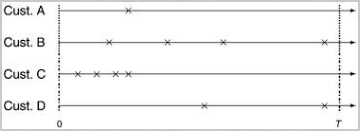


Refer to image above of customers A to D making their purchases, we will take that timeline approach in fitting our model on each individual customer which feeds into our overall likelihood function

## Some Maths Involved (Likelihood Derivation)
`Poisson Distribution` describes probability for the number of purchases that can occur within one time period <br>
A fundamental relationship we can establish: 
* after a customer just made a transaction,for some time constant `t` later, `What is the probability that next transaction hasn't occurred?` 
* denote `Tx` as `Random Variable` for time between this and next transaction and 
* `Xt`as `Poisson Random Variable`, recall that it's independent over time so `λ` can scale by `t` to go beyond one time period

$$ P(T_x>t) = P(X_t = 0) = \underset{0!}{(λt)^0{e^-λt}} = e^{-λt}$$

$$ 1 - P(T_x>t) = P(T_x <_=t) = 1 - e^{-λt}$$

$$ \frac{δP(T_x<=t)}{δt} = P(T_x=t) = λe^{-λt} --- (where)  T_x (is-almost) exp(λ)$$


Now We have effectively `transformed our random variable` from `probability of number of transactions within some time``t` to probability of `t` between transactions  
* It follows an `Exponential Distribution`

To Estimate`λ` we can now `develop our likelihood` which, `for a given customer history`, would be product of all his/her probability of time between the `x-th` and `(x-1)th` purchase`∀x` which is for all x <br>
It can be sectioned into four parts, let `t_x` equal the time of the `xth` purchase:
1. For 1st repeat purchase a customer makes, time period would simply be `difference between time of his repeat purchase and time of his first purchase ever` 
    * the likelihood is equal to: $$λe^{-λt_1}$$
2. For `x-th` repeat purchase, time period would be `difference between time of [x-th] purchase and [(x-1)-th] purchase
    * After [(x-1)-th] purchase, customer has a `p%` chance of dropping out so the likelihood is multiplied by the chance that he/she hasn't became inactive after their previous purchase: $$(1-p)λe^{{-λ}(t_x - t_{(x-1)}}$$  .  Note that we assume a customer cannot become inactive after their first ever purchase so there's no `p` term in (1st point)
3. Between a customer's last observed transaction time and their age: $$t_{max(x),T}$$ have made zero purchases, so the likelihood of that occurring is equal to the summation of<br>
    `3.1.` probability that they have died right after their most recent purchase `p` <br>
    `3.2.` probability that they are still alive but simply have yet to make a purchase yet <br>
* This is equivalent to $$ P(T_x > t) $$ shown above since we are calculating probability that customer's next purchase is beyond $$ T - t_{max(x)} $$ which implies $$ P(X_{T - t_{max(x)}=0}) $$ Likelihood is thus $$ (1-p)e^{-λ(T - t_{max(x)})} $$
 <br>       
 
 `Combined likelihood is then can be defined as:` <br>
$$ = \displaystyle λe^{λ(t_1)}(p + (1 - p)e^{-λ(T - t_{max(x)})})((1 - p)^{x-1}λ^{x-1}e^{-λ(t_{max(x)-t_1})})$$
$$ = \displaystyle (p + (1 - p)e^{-λ(T - t_{max(x)})})((1 - p)^{x-1}λ^{x}e^{-λ(t_{max(x)})})$$
$$ = \displaystyle p(1 - p)^{x-1}λ^xe^{-λ(t_{max(x)})} + (1 - p)^x λ^x e^{-λ(T)}$$

I have now effectively shown that combined likelihood boils down to the `RFM Matrix components` with:
* `Customer Frequency` => $$x$$
* `Customer Recency` => $$ t_{max(x)} $$ 
* `Customer Age` => $$T$$  
There is one last part. Recall that a portion of our customer base have `yet to repurchase (frequency/recency = 0)`and `that we assume they're 100% alive`
* This is equivalent to $$  x,t_{max(x)=0}$$ within $$ (0,T)$$

Using same concept from (3.2), probability that they have yet to purchase is equivalent to $$ e^{-λ(T)} $$
* `Fader` and `Hardie` used a simple indicator trick such that 
    * when a `Customer's frequency equal to zero`, `likelihood should equal to latter equation`
`Our final combined likelihood is written as:` $$ £(λ,p|x,t_{max(x)},T) = δ_{x>0} p(1-p)^{x-1}λ^x e^{-λ(t_{max(x)})}+(1-p)^x λ^x e^{-λ(T)} $$
Here:<br>
$$ δ_{x>0} = 1, when x > 0, and 0- when x = 0$$


Parameters also vary across different customers so it is calculated over `two distributions for a more accurate and flexible fit of data`
* Mathematically, this is done by taking expectation of our equation over both distributions (will show below)

`Fader` and `Hardie` uses this concept for a lot of their models such as `Gamma Gamma sub-model` for monetary value which is discussed later in this notebook

# `Understanding Heterogeneity`
* Related Maths will describe later
* `Lets see for now by Implementing`

### `Fitting Beta-Geometric Negative Binomial Distribution Model`
Our basic customer data(`data_summary`) set up, we can fit a model. 
* We will use `BetaGeoFitter Model` => It provides `Beta-Geometric Negative Binomial Distribution Model` that is common to so-called `“Buy ‘Til You Die” customer lifetime Models`
* To fit model,simply pass in dataframe columns containing `Frequency`, `Recency` and `Tenure` data

##### BG/NBD Model Assumptions
BG/NBD Model Assumes that:
* Each customer makes repeat purchases at different intervals
    * this `interval between purchases is modeled by an exponential distribution` with a `transaction rate - λ`
* After each transaction customer has a `p` - `chance of going inactive (or dying)` which is modelled by a `shifted Geometric distribution`
* These two major parameters are further refined for `Heterogenity` across customers through a `Gamma Distribution` for `λ` and a `Beta Distribution` for `p`. Thus we have four total parameters `r,alpha(Gamma Distribution)` and `a,b(Beta Distribution)` estimated below:

In [25]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data_summary['frequency'], data_summary['recency'], data_summary['T'], )
print(bgf)

[Beta Continuous Random Variable](https://www.geeksforgeeks.org/scipy-stats-beta-python/) <br>
[Gamma Continuous Random Variable](https://www.geeksforgeeks.org/scipy-stats-gamma-python/)<br>
[rvs-in-scipy](https://stackoverflow.com/questions/40333203/rvs-in-scipy-python)

In [26]:
from scipy.stats import beta,gamma
#plotting
gbd = beta.rvs(bgf.params_['a'],bgf.params_['b'],size=50000)
ggd = gamma.rvs(bgf.params_['r'],scale=1./bgf.params_['alpha'],size=50000)

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Heterogenity of $p$')
temp = plt.hist(gbd,20,alpha=0.75)

plt.subplot(122) 
plt.title('Heterogenity of $\lambda$')
temp = plt.hist(ggd,20,alpha=0.75)

`Observe:` <br>
* `Death Rate` centers around the 100% probability but a small portion or no portrion of customer cohort's still have no high chance of dying after each purchase  
* `Heterogenity` of `λ` is mostly distributed around 0 with nothing having small tail

# `Frequency of Repeat Transactions Plot`
After fitting model, we're first interested in seeing how well it is able to relate to our data
* Peter Fader in his [youtube talk](https://www.youtube.com/watch?v=guj2gVEEx4s) says that it fits really well to almost every type of company and then proceeds to prove it with some very convincing plots

`Let's replicate them here for Olist data as a fact check to our model`:
Using `Lifetimes Module` fitter to fit to Olis data set
* `Plotting Heterogenity` of both parameters for learners to visualize
    * Lests see what happens

#### Frequency Fitting

In [27]:
# Plotting a figure with period actual and predicted transactions
from lifetimes.plotting import plot_period_transactions

ax = plot_period_transactions(bgf,max_frequency=7)
ax.set_yscale('log')

Actual and Model bars are similar, our model is pretty good at making prediction
* We plot `expected number of customers that are going to repeat purchase 0, 1, 2, 3 ....,6 times in future`
* `For each number of repeat purchases (x-axis)`, we `plot both what Model predicted` and what `actual numbers` were

`Observation`:<br>
* Little errors in fit for up to 6 repeat purchases <br>
Now we might think, "yeah it's good cause it's probably overfitting with all that complex modelling!", then lets move onto the next fact checker

# `Actual Purchases in Holdout Period vs Predicted Purchases Plot`
In this plot, we separate data into both a `in-sample (calibration)` and `validation (holdout) period`
* `Sample period consists from 2016 (the beginning) to Jan 1,2018`
* `Validation period spans rest of 2018 year` <br>

Plot groups all customers in calibration period by their number of `repeat purchases(x-axis)` and then averages over their repeat purchases in `holdout period (y-axis)`

`Training(2016-2018 end) and test (2018)` <br>
`
We can fit our model with training and see how well it forecasts our customer's out of sample purchasing habit`

In [28]:
# Creating a summary of each customer over a calibration and holdout period by using calibration_and_holdout_data function
## This function creates a summary of each customer over a calibration and holdout period (training and testing, respectively)
### It accepts transaction data and returns a DataFrame of required statistics
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

summary_cal_holdout = calibration_and_holdout_data(transaction_data,'id','date', # # Separating data into holdout/calibration
                                                   calibration_period_end='2018-01-01',#a period to limit calibration inclusive
                                                   observation_period_end='2018-10-17')# final date of study
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'],summary_cal_holdout['T_cal']) # fitting model on calibration data

plot_calibration_purchases_vs_holdout_purchases(bgf,summary_cal_holdout,n=7) # plot the above graph
plt.show()

`This is Predicting Repeat Purchases Out of Sample` <br>
`Observe:`
* `Orange` => fitted model prediction
* `Blue` => our out of sample repeat purchase frequency
* Each `tick on x-axis` is composed of customers that have been grouped such that they have had `x` repeat purchases
* `y-axis` showing mean of that group's subsequent repeat purchase
* We can see in plot that model performs relatively well in identifying repeat purchases within the lower ranges (less than 5) but is unable to properly forecast buying behaviors of customers with more frequent purchasing habits
    * As we can see, up to until `4 repeat purchases`,model is able to `very accurately predict customer base's behavior out of sample`
    * After 4, model does produce a lot more error and under-estimates average repeat purchases
        * `This is due to lack of data for those large repeat purchasing customers`

# Repeat Sales accord to Model
Visualizing Repeat Sales from Model's point of view <br>

Up to this point we've looked at `how Purchasing Model is able to accurate predict future repeat purchases of customer base` <br>
We've never considered up till now:
* `How our input data(Frequency and Recency) is interpreted by model` as well as 
* `How their interaction affects model output`  

**`Now we will create two plot that are called Recency/Frequency (RF) Plots`**

### Math Involved
Authors of customer probability models have consistently provided three key outputs that their model should be able to infer.  We've seen some already and below plots uses them as well:
1. Probability that a customer has made `x` repeat purchases within `t` periods, given by: $$ P(X(t) = x|λ,p) $$
2. Expected number of repeat purchases for a customer within `t` periods, given by: $$ E(X(t)|λ,p) $$
3. Expected number of repeat purchases for a customer within `t` periods given his/her prior purchasing history, given by: $$ E(X(t)|λ,p,x,t_{max(x),T}) $$ it can be seen as a future forecast of customer's purchases

Derivation for these three components are provided in detail from [original paper](http://www.brucehardie.com/papers/bgnbd_2004-04-20.pdf)

# Recency anf Frequency Plots
`RF Plots` maps a `customer's expected purchases` by next year and `probability that they're alive` given his or her frequency/recency
* Intuitively, `Customers with High Frequency and Recency are expected to purchase more in future and have a higher chance of being alive`

`Consider`: a customer bought from us every day for three weeks straight, and we haven’t heard from them in months. What are the chances they are still “alive”? Pretty small
* On the other hand, a customer who historically buys from us once a quarter, and bought last quarter, is likely still alive
* We can visualize this relationship using the `Frequency/Recency matrix`
    * this matrix computes expected number of transactions an artificial customer is to make in next time period, given his or her recency(age at last purchase) and frequency(number of repeat transactions he or she has made)
    
    
For a given random customer with his/her `observed(x,𝑡𝑥)` we can calculate through model, expected number of purchases within a time period which we will set equivalent to a year -`𝑇=365`.

In [29]:
from lifetimes.plotting import plot_frequency_recency_matrix


plot_frequency_recency_matrix(bgf,T=365)
plt.show()

`Observation:` <br>
Customers in faded color zone are of interest as well since they are 50/50 on leaving business but we can still expect them to purchase about 1 to 1.5 times during next year
* These are customers that may need a little customer servicing/or maybe discounts (can say what exactly as we have to analysed other datasets in brief) to come back and buy more

For a given random customer with his/her `observed(x,𝑡𝑥)`, we can `calculate probability` as of today that they are still alive <br>
In other words, `are they still interested in maintaining a purchasing relationship with Olist in future?`

In [30]:
from lifetimes.plotting import plot_probability_alive_matrix


plot_probability_alive_matrix(bgf)
plt.show()

`Observation:` <br>
 It is interesting to note that for a fixed recency, customer's with more frequency are more likely to be considered dead <br>
 
 This is a property of model that illustrates a clear behavioral story:
 * A customer making more frequent purchases is more likely to die off if we observe a longer period of inactivity than his/her previous intervals 

`For example:` <br>
Given two customers X and Y that both last purchased 1.5 years ago(`𝑡𝑥 = appx.2300 days`) but purchased 10 and 30 times respectively, we believe that it is more likely that customer Y has died(`𝑝=0%`) while customer X still has a fair chance of being alive and making purchases in future (`𝑝= appx40%`) maybe.

# Projecting Future Sales from Current Customers
We can infer from our existing customers, expected number of purchases that they're going to make in next X amount of days

`Who can leverage it???`<br>
* Businesses looking to forecast their existing customer sales can leverage this calculation, as `it inspects each observed customer and predicts how much this individual will buy over forecast period`
* Also useful as it can directly link back to `marketing` and `operations function` as both a form of evaluation for previous projects or as a starting point for new changes

`For Example:` <br>
* Say we want to begin a rollout of a new discount program that's awarded to our best customers
* We want to exclusively target six customers that we feel will revisit our stores within next three months

See how Model pick thouse for us:

### `Maths Top Six Customers`
Component used from `bg.nbd model` is `conditional_expected_number_of_purchases_up_to_time function` from `lifetimes module`
* This is equivalent to this formula $$ E[T(t)|r,α,a,b,x,t_{max(x)},T] $$ where we feed in a customer's summary history and model infers their future expected purchases
* This is simply done by first inferring population expected future purchases which is $$ E[T(t)|r,α,a,b] $$ and multiplying it by the probability that customer is still alive by `T`.

Refer to this [original paper](http://www.brucehardie.com/papers/bgnbd_2004-04-20.pdf) for detailed derivation

In [32]:
t = 31*3 #three months time where each month is of 31 days
data_summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,data_summary['frequency'],
                                                                                              data_summary['recency'],
                                                                                              data_summary['T'])
best_projected_6_customer = data_summary.sort_values(by='predicted_purchases').tail(6)

data_summary.sort_values(by='predicted_purchases').tail(6)

`Observation:`
Listed above are our top six customers that model expects them to purchase in next three months
* `predicted_purchases column`:
    * lists expected number of transactions of these 6 customers while 
* `Other four columns` lists their current `RFM metrics`

It is clear that our best customers are often individuals that are relatively young and have made at least 4 repeat orders with the latest one being very recently
* `BG/NBD Model` believes these individuals will be making more purchases within near future as they are our current best customers

In [49]:
best_projected_6_customer

# Historical (customer) Paths
One last feature that `lifetimes package includes` is: `ability to visualize a customer's historical purchase history along with probability that he/she is still active at each time period`

`This feature is useful in trying to visualize patterns that specific customers may transact at`

`NOTE:`<br>
Some of most common patterns are `Cyclical Purchases(especially for businesses)` as well as `different group behaviors`
* purchasing a lot in a short period then die in contrast to purchasing frequently over a longer period

**`Let's take our top six customers and see how they have historically shopped`**
* for derivation of probability of alive over time see [THIS](http://www.brucehardie.com/notes/021/palive_for_BGNBD.pdf)

In [52]:
#plot_history_alive is used to draw a graph showing probability of being alive for a customer in t-time
from lifetimes.plotting import plot_history_alive 


fig = plt.figure(figsize=(12,12))
for index,transaction_id_6 in enumerate(best_projected_6_customer.index.tolist()):
    ax = plt.subplot(4,2,index + 1)
    
    best_time = data_summary.loc[transaction_id_6]['T'] + 31 #add a month #extracting 6 best time
    best_transaction_id = transaction_data[transaction_data['id'] == transaction_id_6]
    trans_data[trans_data['Customer ID'] == i]
    
    plot_history_alive(bgf,best_time,best_transaction_id,'date',freq='D',ax=ax)
    ax.set_title('id: '+str(transaction_id_6))
    plt.xticks(rotation=25)
fig.tight_layout()

As this above function is not working, so the Error is that the id column is in alphanumeric which i have no idea how to change to int or float.I cannot notice interesting things in above graph

Based on these graphs, businesses can come up with some rule-based system to identify important customers and cluster them into segments that can be explained economically
* Businesses can then further strengthen relationship with these segments through different interactions

`Conclusion:` <br>
We have summarized functions available in lifetimes package to apply to real-life datasets for customer analysis
* Additionally, we have described intuition and math that goes behind these functions to get more into it
* It's a very powerful model and a lot of insight and further decisions can be gained from it

We only listed a few examples of real application, in real time businesses we can leverage this analysis and can use this as a tool to separate and group specific customers for future interactions.



--------
 
--------

**`Now its time to applying Monetary figures to this model and showing how to create a discounted cash flow valuation model from bottom up`**

`Discounted Cash Flow(DCF)` a valuation method used to `estimate value of an investment` based on its `expected future cash flows`

# Customer Value in any Currency: Gamma-Gamma Model
In a traditional `RFM matrix`, each customer can be assigned a monetary value with his or her customer profile
* This value is usually calculated as `mean transaction value of his or her purchasing history` 
* `Transaction Value` is a loosely based word around any metric that business might be interested in
* Olist reports an average profit margin of x%, we will multiply that by revenue <br>

`Note:`<br>
* We are only interested in customers that have repeat purchases

In [ ]:
data_summary.head()

In [ ]:
returning_customers_summary = summary[summary['monetary_value'] > 0]

ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(returning_customers_summary['frequency'],returning_customers_summary['monetary_value'])
transaction_spend = ggf.conditional_expected_average_profit(summary['frequency'],summary['monetary_value']).mean()
print(transaction_spend)

In [ ]:
# GammaGammaFitter is used to estimate average monetary value of customer transactions
from lifetimes import GammaGammaFitter

ret_cust_data = data_summary[data_summary['frequency'] > 0]
ret_cust_data['monetary_value'] = ret_cust_data['monetary_value']*0.50 #set monetary value to gross profit only assuming gross profit of 0.50%

ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(ret_cust_data['frequency'],ret_cust_data['monetary_value'])
p,q,v = ggf._unload_params('p', 'q', 'v')

print(ggf)